In [1]:
import colorsys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
# Data files use the device name as the keys for my reference. For graphics, we
# want to use the CPU model in roughly performance order.
device_to_cpu = {
    "Graham-PC-Neon": "i7-6700k",
    "pve1": "i5-11400t",
    "pve2": "i5-10500t",
    "pve3": "i9-9900",
    "pve4": "i7-13700t",
    "DS920": "J4125",
    "rpi4": "RPi 4",
    "cloverlea-pve": "i5-6500",
}

cpu_order = [
    "i7-13700t",
    "i5-11400t",
    "i5-10500t",
    "i9-9900",
    "i7-6700k",
    "J4125",
    "RPi 4",
    # Remote device goes last
    "i5-6500",
]

In [3]:
def load_data_file(
    path: str,
    index_name: str | None = "Source",
    columns_name: str | None = "Target",
) -> pd.DataFrame:
    df = pd.read_csv(path, index_col=0)
    df = df.rename(index=device_to_cpu, columns=device_to_cpu)

    df.index.names = [index_name]
    df.columns.names = [columns_name]


    # Reorder columns
    columns = set(df.columns)
    df = df[[x for x in cpu_order if x in columns]]
    
    # Reorder rows
    index = set(df.index)
    df = df.reindex([x for x in cpu_order if x in index])

    return df

# Direct Connections (No VPN)

Connections are established directly between devices on the local network. All local devices use an RTL8125B 2.5 GbE NIC, connected through Unifi switches (but with varying numbers of switches between them).

## Remote Connections

The i5-6500 device is remote. The sites are ~100 km away, and both have a (theoretically) gigabit WAN connection. Connections with this node were done by port forwarding to the counterpart on my home side

Notes on the remote device performance:
- The remote side is behind CGNAT, so I can't port forward on its network. Hence the tests with the i5-6500 as the target were conducted with iperf reverse mode (`-R`) initiated from the remote side.
  - This may explain the generally ~200 Mbps slower speeds when that node is used as a target (ie reverse mode)
- The performance from RPi 4 -> i5-6500 (again, using iperf reverse mode in the other direction) is unusually high and 937 Mbps, but was repeatable. This may have something to do with the Raspberry Pi being the only device that was plugged directly into my router, the rest were behind switches.

### Unifi Site Magic

My home uses a Unifi UCG Max and the remote side a Unifi Dream Machine router, so we can also test remote connections using Unifi Site Magic mesh VPN. This is provided for comparison against Tailscale only, it is not part of subsequent experiments.


| direction / target | Graham-PC-Neon | pve1  | pve2  | pve3  | pve4  | rpi4  | DS920 |
| ------------------ | -------------- | ----- | ----- | ----- | ----- | ----- | ----- |
| incoming           | 0.487          | 0.490 | 0.503 | 0.495 | 0.589 | 0.532 | 0.584 |
| outgoing           | 0.557          | 0.483 | 0.553 | 0.498 | 0.568 | 0.512 | 0.488 |

- "incoming" means the device is the client and cloverlea-pve is the server
- "outgoing" means cloverlea-pve is the client and the device is the server


In [4]:
df_no_vpn = load_data_file("data/no-vpn.csv")

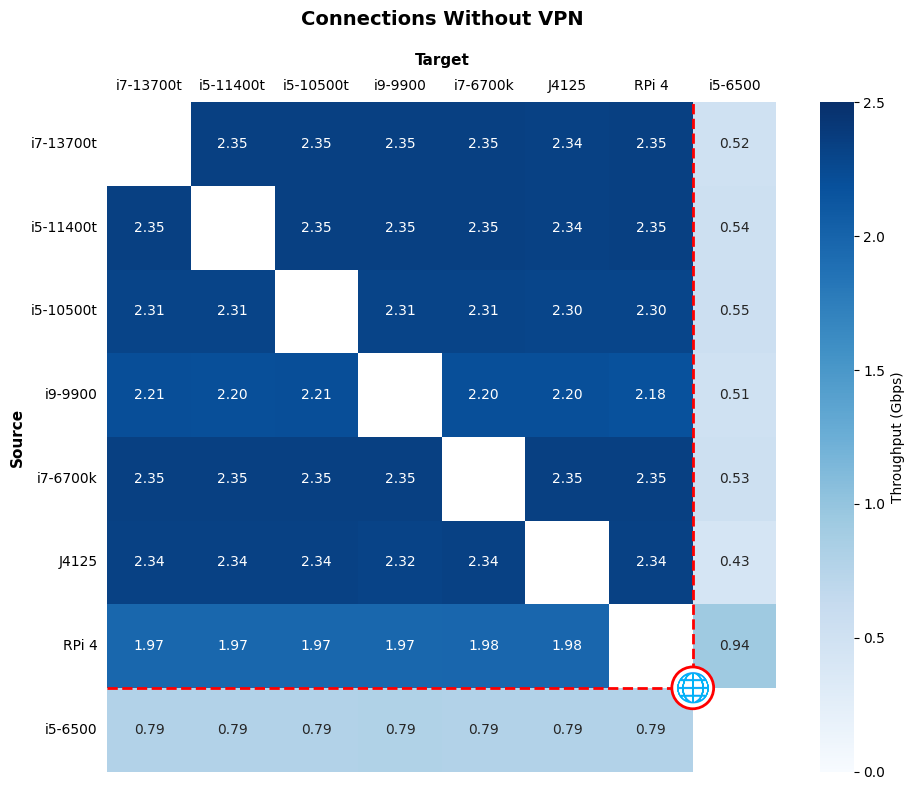

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    df_no_vpn,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    vmin=0,
    vmax=2.5,
    cbar_kws={"label": "Throughput (Gbps)"},
    ax=ax
)

ax.tick_params(axis="both", width=0, rotation=0)

ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.set_xlabel(ax.get_xlabel(), fontweight="bold", fontsize=11, labelpad=10)

ax.set_ylabel(ax.get_ylabel(), fontweight="bold", fontsize=11)

# Dividing line for WAN boundary
ax.axhline(y=7, xmax=7/8, color="red", linestyle="--", linewidth=2)
ax.axvline(x=7, ymin=1/8, color="red", linestyle="--", linewidth=2)

# Icon for WAN
globe = plt.imread("globe.png")
size = 0.2
extent = [7-size, 7+size, 7-size, 7+size]
ax.imshow(globe, extent=extent, aspect='equal', zorder=11)
circ = plt.Circle((7, 7), size+0.05, fill=True, facecolor="white", edgecolor="red", linewidth=2, zorder=10)
ax.add_patch(circ)

ax.set_title("Connections Without VPN", fontsize=14, fontweight="bold", pad=20)

plt.tight_layout()
fig.savefig("output/without_vpn.png", dpi=300)


# Tailscale Direct Connections

Tailscale is run on each device, and iperf connections are made to the Tailscale IP of the target device with `iperf3 -c $(tailscale ip -4 <node>)`.

All connections were direct (not through DERP). For the remote site, Unifi Site Magic was disabled.

In [6]:
df_ts = load_data_file("data/tailscale-direct.csv")

In [7]:
def compute_retention(
    *,
    df_before: pd.DataFrame,
    df_after: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Compute the % retention between two dataframes with the same columns / indexes

    Retention % is (df_after / df_before) * 100

    Args:
        df_before: Starting DataFrame
        df_after: DataFrame with the change

    Returns: Tuple with:
        1. A DataFrame with the retention values
        2. A DataFrame with strings that show the after and retention, to be used as annotations
    """

    assert (df_before.columns == df_after.columns).all()
    assert (df_before.index == df_after.index).all()

    df_retention = df_before / df_after * 100

    df_annot = pd.DataFrame(index=df_ts.index, columns=df_ts.columns)

    for i in df_annot.index:
        for j in df_annot.columns:
            before = df_before.loc[i, j]
            ret = df_retention.loc[i, j]
            
            if pd.isna(before) or pd.isna(ret):
                df_annot.loc[i, j] = np.nan
            else:
                df_annot.loc[i, j] = f"{before:.2f}\n({ret:.0f}%)"

    return (df_retention, df_annot)

In [8]:
df_retention, df_annot = compute_retention(
    df_before=df_ts,
    df_after=df_no_vpn,
)

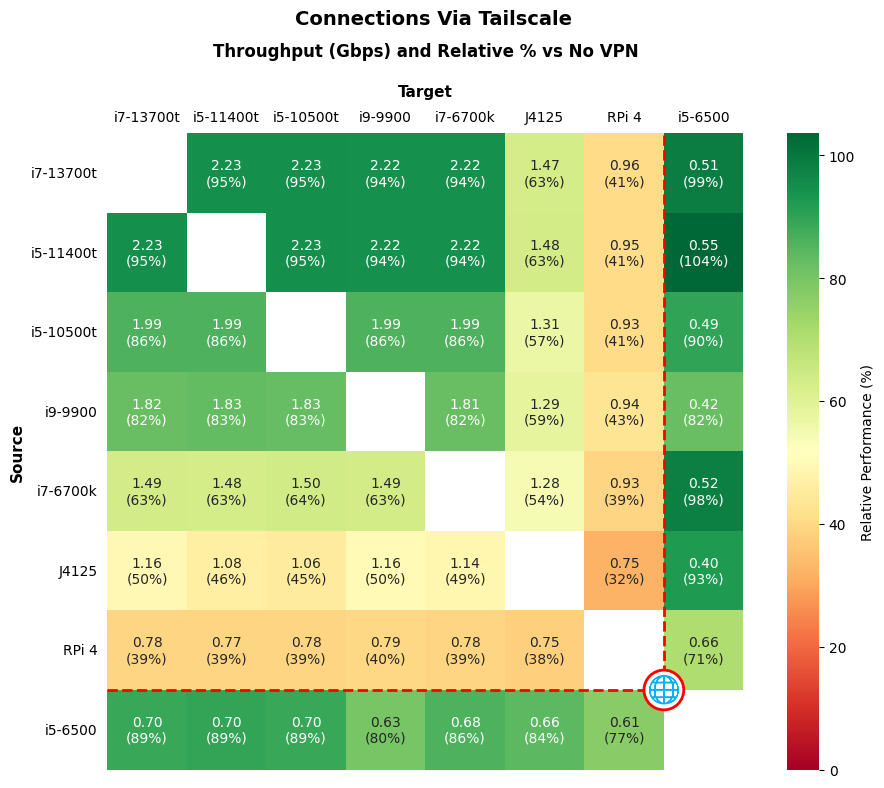

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    df_retention,
    annot=df_annot.values,
    fmt="",
    cmap="RdYlGn",
    vmin=0,
    cbar_kws={"label": "Relative Performance (%)"},
    ax=ax
)

ax.tick_params(axis="both", width=0, rotation=0)

ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.set_xlabel(ax.get_xlabel(), fontweight="bold", fontsize=11, labelpad=10)

ax.set_ylabel(ax.get_ylabel(), fontweight="bold", fontsize=11)

# Dividing line for WAN boundary
ax.axhline(y=7, xmax=7/8, color="red", linestyle="--", linewidth=2)
ax.axvline(x=7, ymin=1/8, color="red", linestyle="--", linewidth=2)

# Icon for WAN
globe = plt.imread("globe.png")
size = 0.2
extent = [7-size, 7+size, 7-size, 7+size]
ax.imshow(globe, extent=extent, aspect='equal', zorder=11)
circ = plt.Circle((7, 7), size+0.05, fill=True, facecolor="white", edgecolor="red", linewidth=2, zorder=10)
ax.add_patch(circ)

plt.suptitle("Connections Via Tailscale", fontsize=14, fontweight="bold")
ax.set_title("Throughput (Gbps) and Relative % vs No VPN", fontsize=12, fontweight="bold", pad=20)

plt.tight_layout()
fig.savefig("output/tailscale_retention.png", dpi=300)

# Subnet Routers

Subnet routers were tested with 3 common targets (iperf3 servers):
- i5-10500t: A good "average" performer, capable of sending/receiving near-2.5 Gbps without a VPN
- Celeron J4125 (Synology DS920+): My actual most common target where I want the best performance possible
- Raspberry Pi 4: Well-known reference. Worst performer when using Tailscale

All tests were performed on the LAN (the remote i5-6500 is out). For each set of tests, a /32 for just the target device was advertised - eg `tailscale set --advertise-routes="192.168.2.10/32"`. This ensured that devices using `--accept-routes` routed over Tailscale instead of over the LAN. This was verified for each test by making sure `tailscale status` was reporting activity.

Each of the above targets was also used as a subnet router, which is a common configuration (subnet router that can route to itself). The i5-10500t running Proxmox and Raspberry Pi 4 were smart enough to route the connection right out of the tailscale interface with no additional network hop, so performance was identical to using Tailscale directly. The Synology DS920+ running DSM 7.2 did not do this, so subnet routing to itself resulted in an additional network hop and worse performance.

Each test was performed in the forward direction (iperf client -> server) and reverse (`-R` flag on iperf client). As seen in the above results, devices tend to perform better as receivers than senders.

In [10]:
# Tests targeting pve2 (i5-10500t), forward and reverse
df_sr_pve2_forward = load_data_file(
    "data/sr-target-pve2-forward.csv",
    index_name="Client",
    columns_name="Subnet Router",
)
df_sr_pve2_rev = load_data_file(
    "data/sr-target-pve2-reverse.csv",
    index_name="Client",
    columns_name="Subnet Router",
)

In [11]:
# Tests targeting a Raspberry Pi 4, forward and reverse
df_sr_pi_forward = load_data_file(
    "data/sr-target-rpi4-forward.csv",
    index_name="Client",
    columns_name="Subnet Router",
)
df_sr_pi_rev = load_data_file(
    "data/sr-target-pve2-reverse.csv",
    index_name="Client",
    columns_name="Subnet Router",
)

In [12]:
# Tests targeting a Synology DS920+ (Celeron J4125), forward and reverse
df_sr_ds920_forward = load_data_file(
    "data/sr-target-ds920-forward.csv",
    index_name="Client",
    columns_name="Subnet Router",
)
df_sr_ds920_rev = load_data_file(
    "data/sr-target-ds920-reverse.csv",
    index_name="Client",
    columns_name="Subnet Router",
)

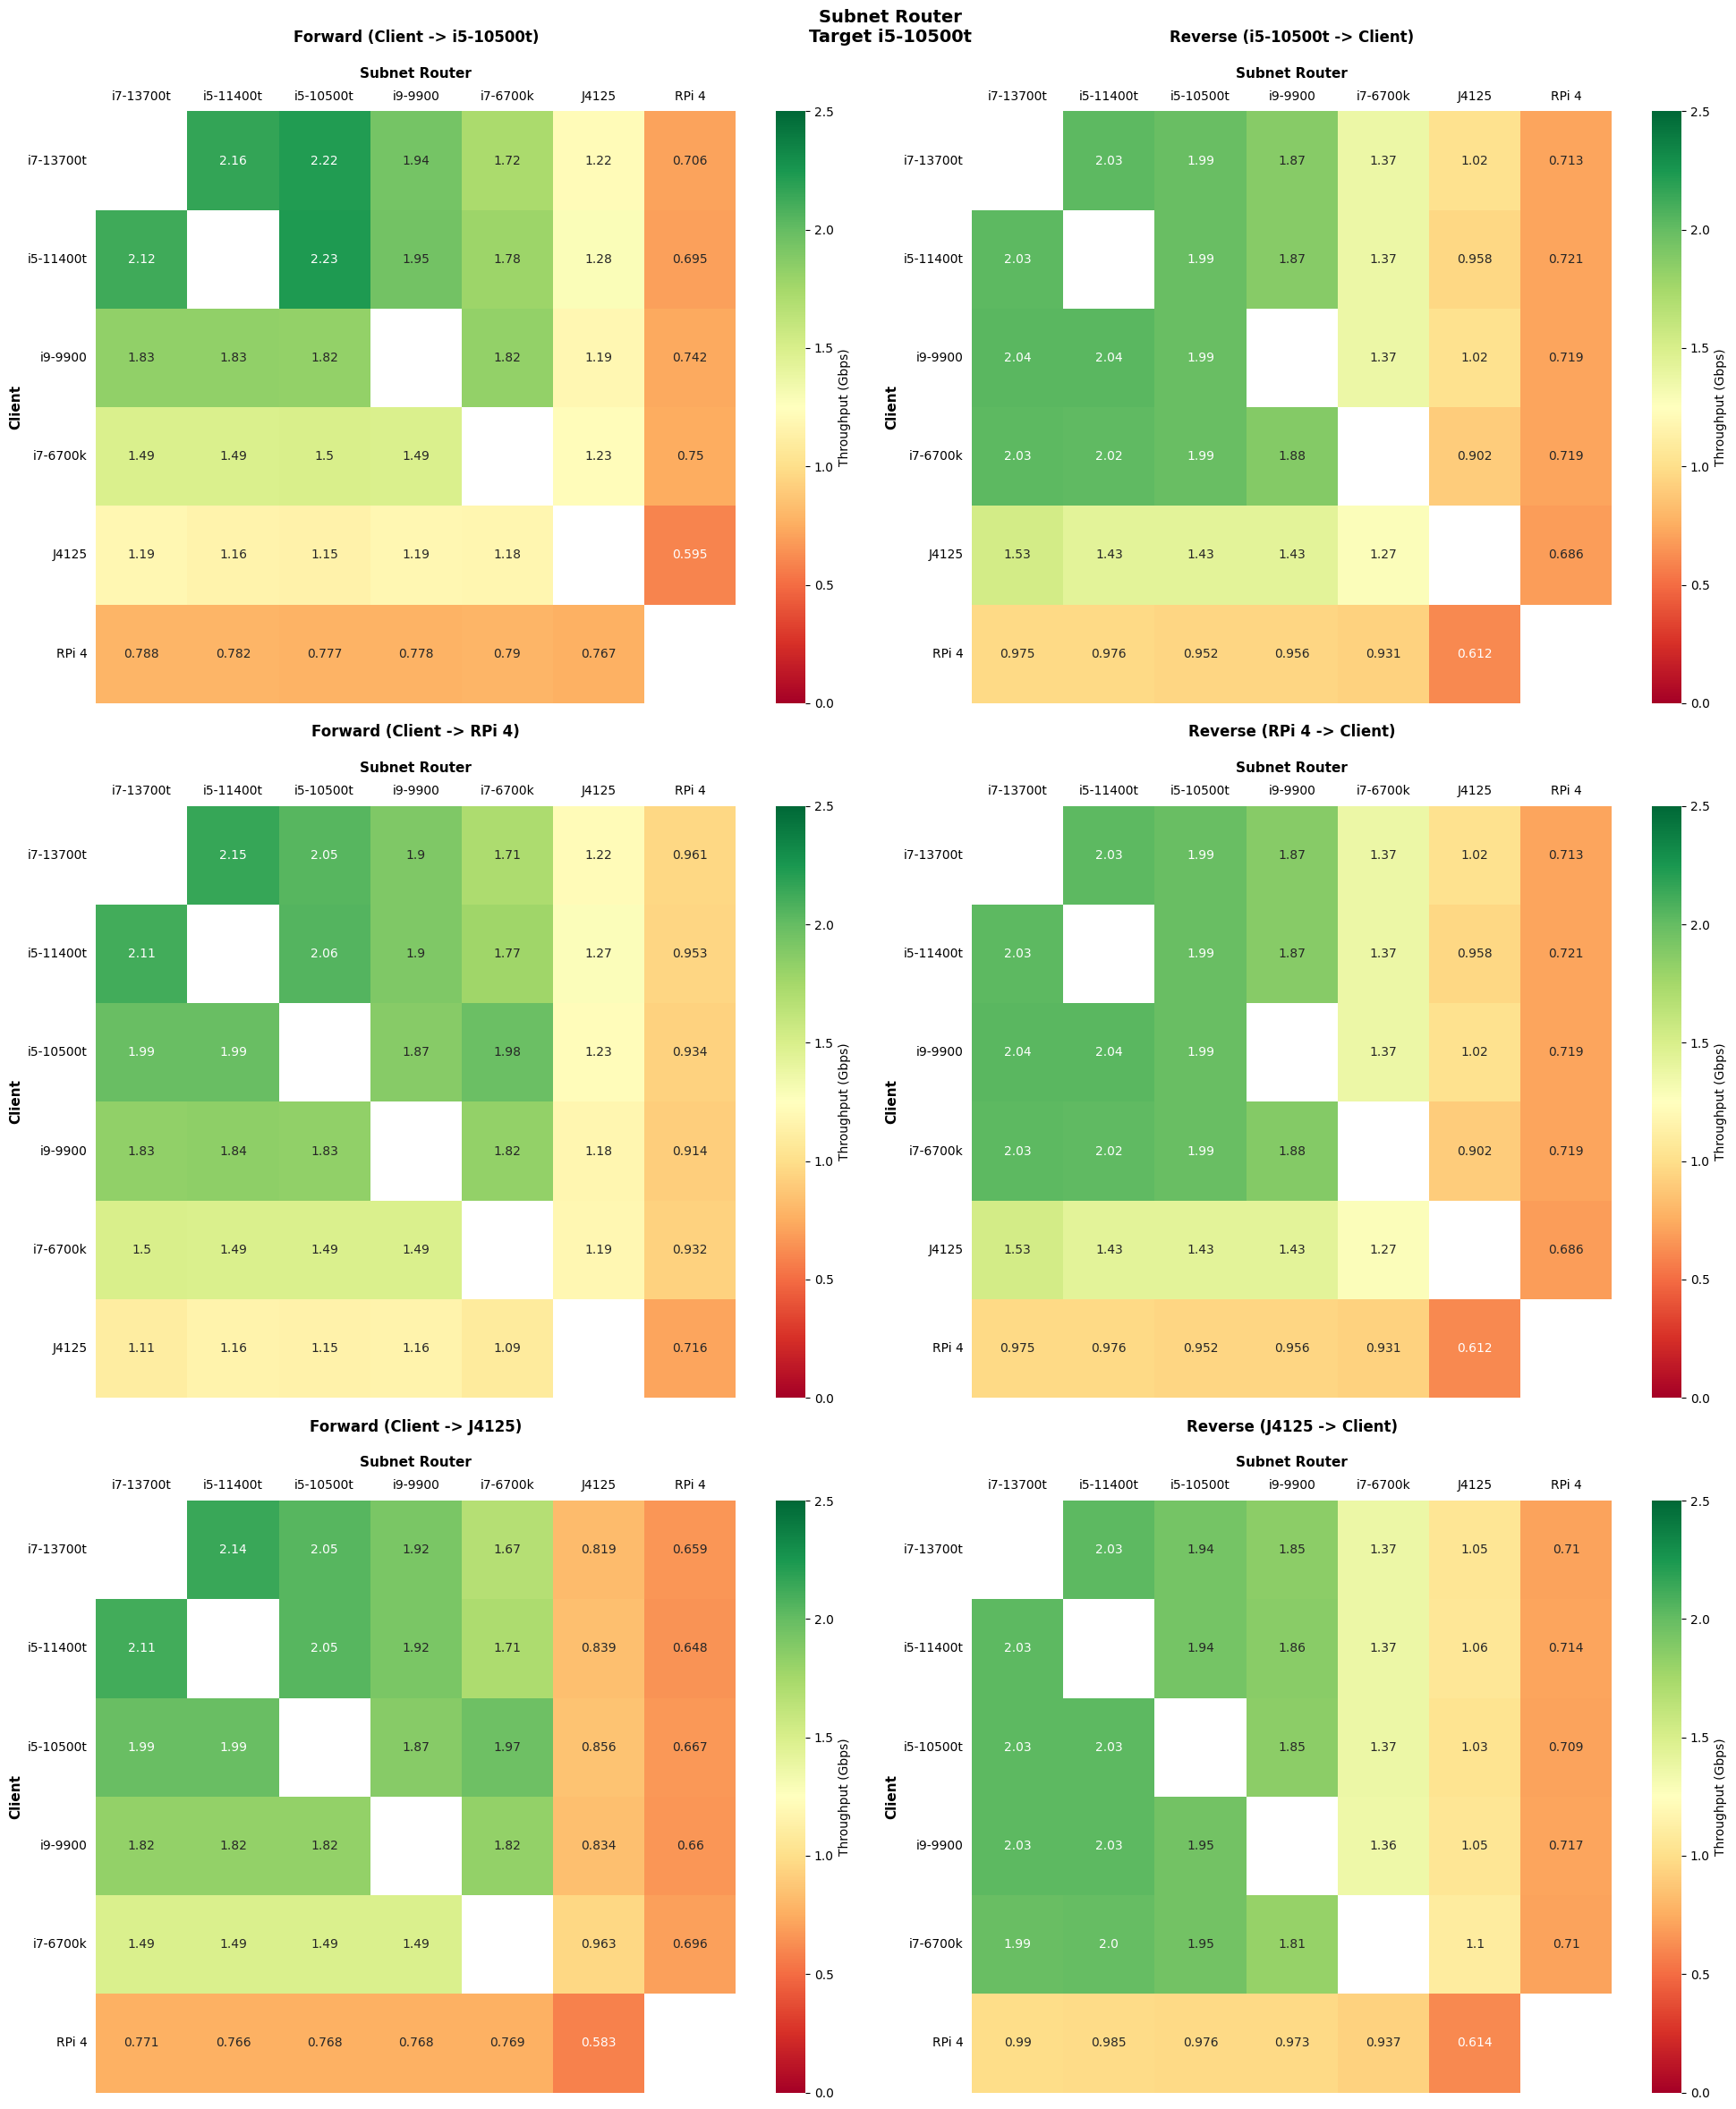

In [13]:
# Combined figure with raw throughput numbers, forward and reverse
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20, 24))

def make_subplot(
    data,
    *,
    ax,
    title,
    annot: pd.DataFrame | bool = True,
    vmin: float | None = 0,
    vmax: float | None = None,
    cmap="RdYlGn",
    cmap_label="Throughput (Gbps)",
):
    sns.heatmap(
        data,
        annot=annot,
        fmt="",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar_kws={"label": cmap_label},
        ax=ax,
    )

    ax.tick_params(axis="both", width=0, rotation=0)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    ax.set_xlabel(ax.get_xlabel(), fontweight="bold", fontsize=11, labelpad=10)
    
    ax.set_ylabel(ax.get_ylabel(), fontweight="bold", fontsize=11)
    ax.set_title(title, fontsize=12, fontweight="bold", pad=20)
        

plt.suptitle("Subnet Router\nTarget i5-10500t", fontsize=14, fontweight="bold")

make_subplot(df_sr_pve2_forward, ax=ax1, vmax=2.5, title="Forward (Client -> i5-10500t)")
make_subplot(df_sr_pve2_rev, ax=ax2, vmax=2.5, title="Reverse (i5-10500t -> Client)")
make_subplot(df_sr_pi_forward, ax=ax3, vmax=2.5, title="Forward (Client -> RPi 4)")
make_subplot(df_sr_pi_rev, ax=ax4, vmax=2.5, title="Reverse (RPi 4 -> Client)")
make_subplot(df_sr_ds920_forward, ax=ax5, vmax=2.5, title="Forward (Client -> J4125)")
make_subplot(df_sr_ds920_rev, ax=ax6, vmax=2.5, title="Reverse (J4125 -> Client)")

plt.tight_layout()
fig.savefig("output/subnet-routers.png", dpi=300)

In [14]:
def compute_sr_retention(
    *,
    df_before: pd.DataFrame,
    df_sr: pd.DataFrame,
    target: str,
    reverse: bool = False,
    index_name: str = "Source"
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Compute retention (relative performance) of a subnet router configuration.
    
    Returns: Tuple with:
        1. A DataFrame with the retention values
        2. A DataFrame with strings that show the after and retention, to be used as annotations
    """
    df_ret = pd.DataFrame(index=df_sr.index, columns=df_sr.columns, dtype=np.float64)
    df_annot = pd.DataFrame(index=df_sr.index, columns=df_sr.columns)

    for client in df_ret.index:
        for sr in df_ret.columns:
            if reverse:
                before = df_before.loc[target, client]
            else:
                before = df_before.loc[client, target]

            val = df_sr.loc[client, sr]

            if pd.isna(before) or pd.isna(val):
                df_ret.loc[client, sr] = np.nan
                df_annot.loc[client, sr] = np.nan
                continue
                
            ret = val / before * 100
            df_ret.loc[client, sr] = ret
            df_annot.loc[client, sr] = f"{val:.2f}\n({ret:.0f}%)"

    df_ret.index.name = index_name
    df_annot.index.name = index_name

    return (df_ret, df_annot)            

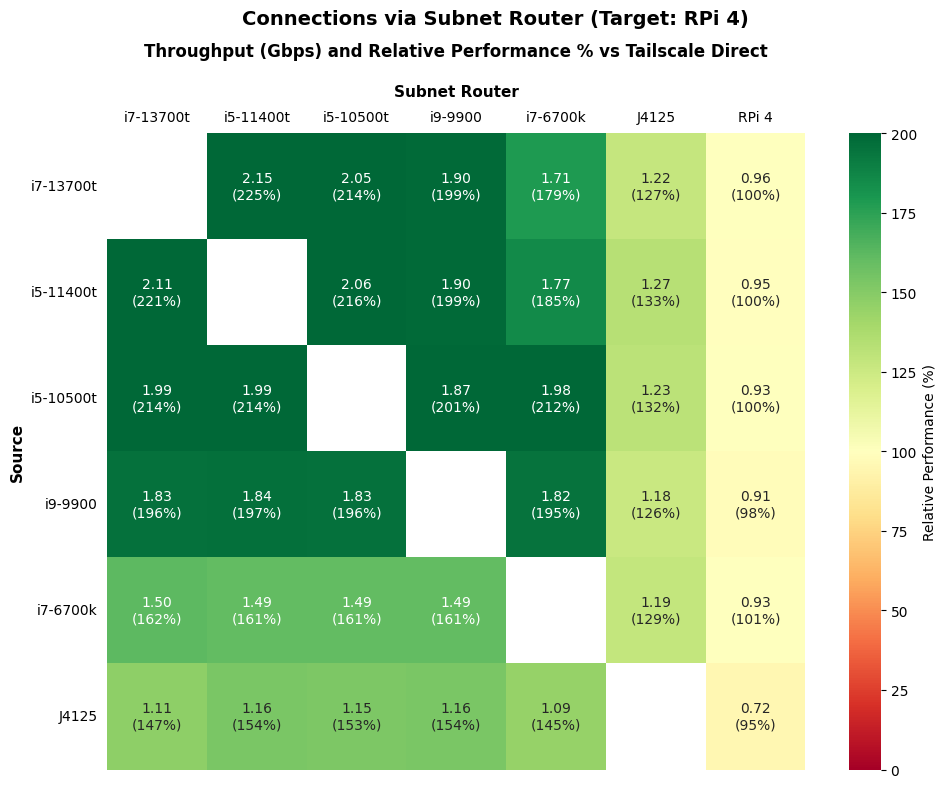

In [15]:
df_ret, df_annot = compute_sr_retention(
    df_before=df_ts,
    df_sr=df_sr_pi_forward,
    target="RPi 4",
    reverse=False
)

fig, ax = plt.subplots(figsize=(10, 8))

plt.suptitle("Connections via Subnet Router (Target: RPi 4)", fontsize=14, fontweight="bold")

make_subplot(
    df_ret,
    annot=df_annot.values,
    ax=ax,
    vmin=0,
    vmax=200,
    title="Throughput (Gbps) and Relative Performance % vs Tailscale Direct",
    cmap="RdYlGn",
    cmap_label="Relative Performance (%)",
)

plt.tight_layout()
fig.savefig("output/sr-target-rpi-heatmap.png", dpi=300)

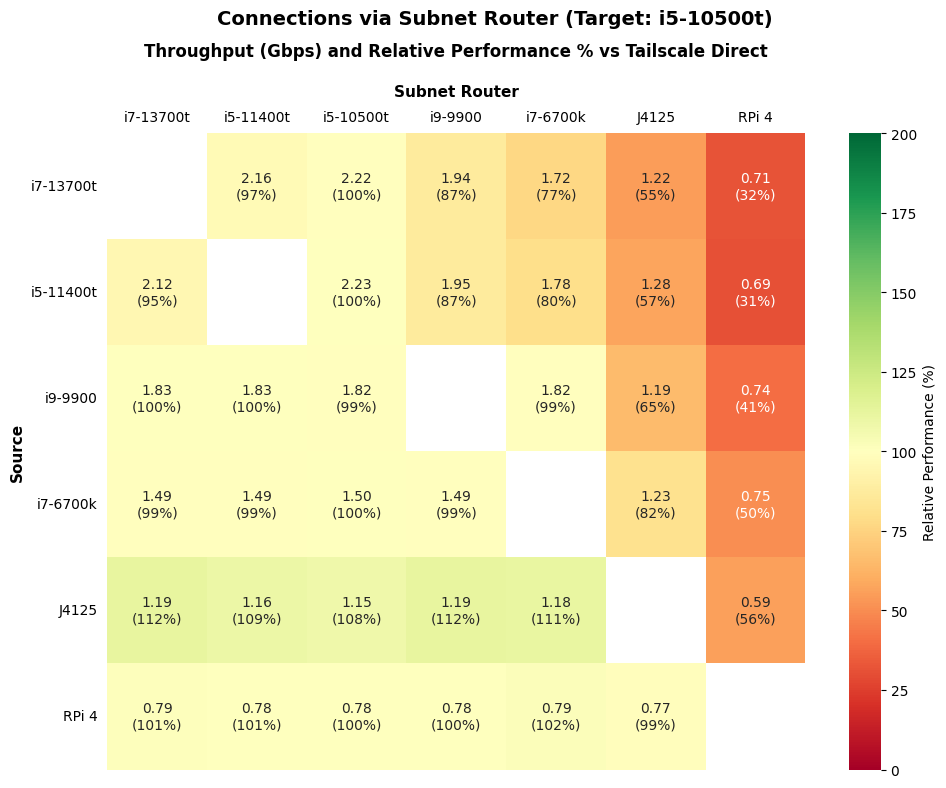

In [16]:
df_ret, df_annot = compute_sr_retention(
    df_before=df_ts,
    df_sr=df_sr_pve2_forward,
    target="i5-10500t",
    reverse=False
)

fig, ax = plt.subplots(figsize=(10, 8))

plt.suptitle("Connections via Subnet Router (Target: i5-10500t)", fontsize=14, fontweight="bold")

make_subplot(
    df_ret,
    annot=df_annot.values,
    ax=ax,
    vmin=0,
    vmax=200,
    title="Throughput (Gbps) and Relative Performance % vs Tailscale Direct",
    cmap="RdYlGn",
    cmap_label="Relative Performance (%)",
)

plt.tight_layout()
fig.savefig("output/sr-target-pve2-heatmap.png", dpi=300)

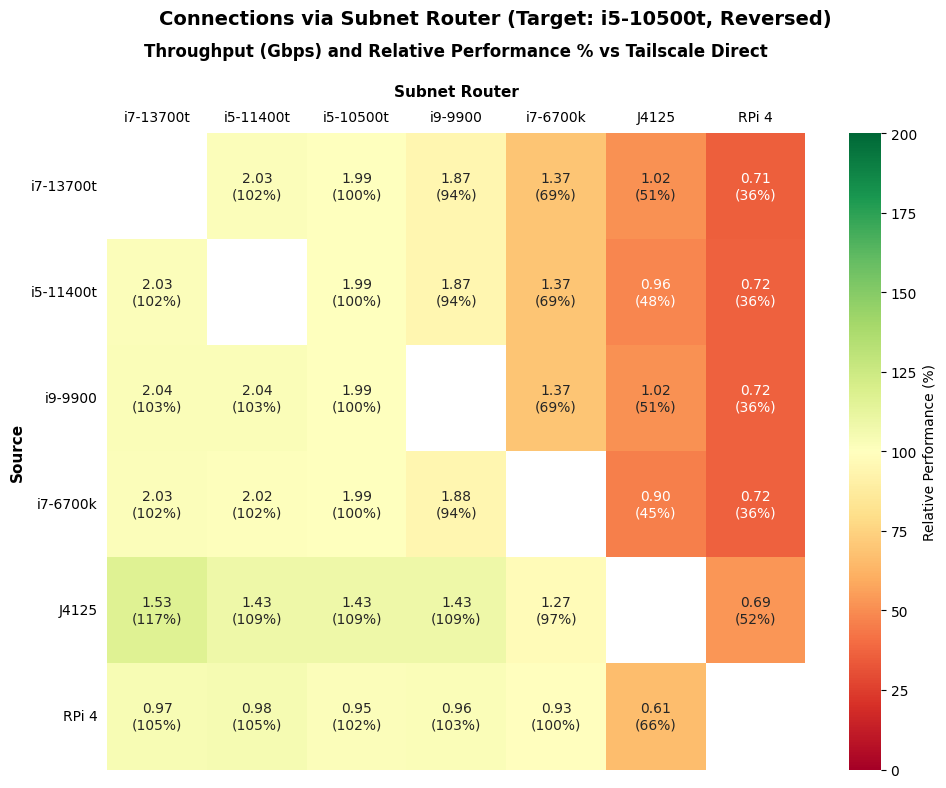

In [17]:
df_ret, df_annot = compute_sr_retention(
    df_before=df_ts,
    df_sr=df_sr_pve2_rev,
    target="i5-10500t",
    reverse=True
)

fig, ax = plt.subplots(figsize=(10, 8))

plt.suptitle("Connections via Subnet Router (Target: i5-10500t, Reversed)", fontsize=14, fontweight="bold")

make_subplot(
    df_ret,
    annot=df_annot.values,
    ax=ax,
    vmin=0,
    vmax=200,
    title="Throughput (Gbps) and Relative Performance % vs Tailscale Direct",
    cmap="RdYlGn",
    cmap_label="Relative Performance (%)",
)

plt.tight_layout()
fig.savefig("output/sr-target-pve2-reverse.png", dpi=300)

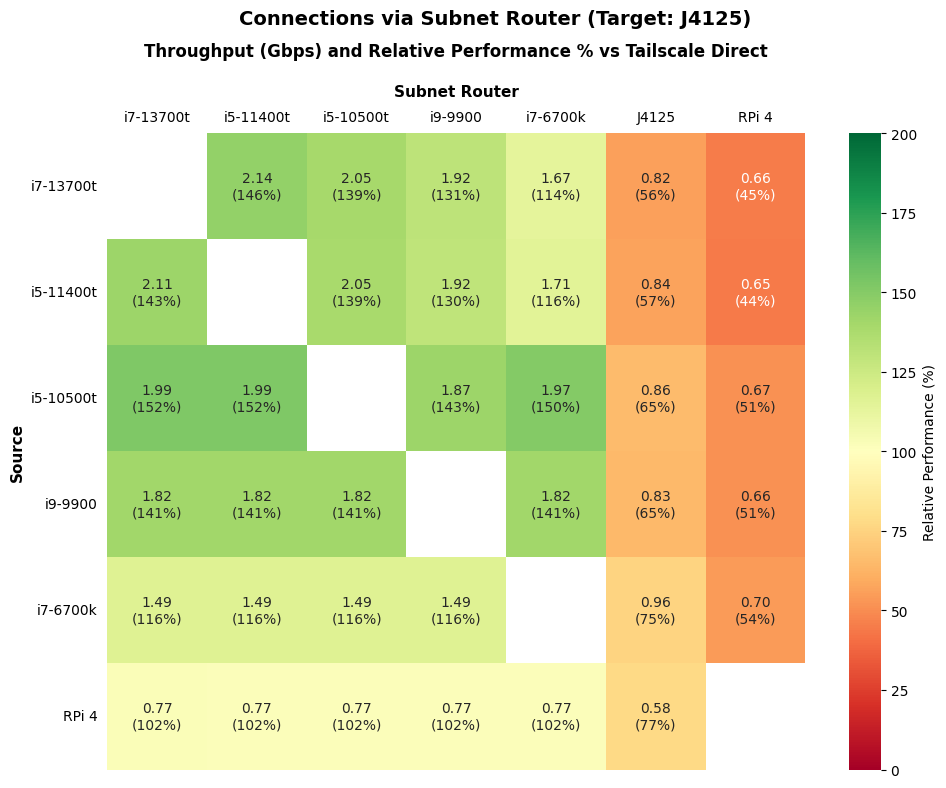

In [18]:
df_ret, df_annot = compute_sr_retention(
    df_before=df_ts,
    df_sr=df_sr_ds920_forward,
    target="J4125",
    reverse=False
)

fig, ax = plt.subplots(figsize=(10, 8))

df_ret.index.name = "Source"

plt.suptitle("Connections via Subnet Router (Target: J4125)", fontsize=14, fontweight="bold")

make_subplot(
    df_ret,
    annot=df_annot.values,
    ax=ax,
    vmin=0,
    vmax=200,
    title="Throughput (Gbps) and Relative Performance % vs Tailscale Direct",
    cmap="RdYlGn",
    cmap_label="Relative Performance (%)",
)

plt.tight_layout()
fig.savefig("output/sr-target-ds920-heatmap.png", dpi=300)

## Summarized Throughput - Target: Raspberry Pi 4

In [19]:
def compare_subnet_routers(
    *,
    df_sr: pd.DataFrame,
    target_cpu: str,
    target_name: str | None = None,
):
    if not target_name:
        target_name = target_cpu
        
    devices = ["i7-13700t", "i5-11400t", "i5-10500t", "i9-9900", "i7-6700k", "J4125", "RPi 4"]
    devices = [x for x in devices if x != target_cpu]
    
    subnet_routers = ["RPi 4", "J4125", "i9-9900", "i5-11400t", "i7-13700t"]
    # subnet_routers = [x for x in subnet_routers if x != target_cpu]
    
    
    df = pd.DataFrame([
        df_ts.loc[devices, target_cpu].rename("Direct Tailscale"),
        *[df_sr.loc[devices, cpu].rename(f"{cpu} Subnet Router") for cpu in subnet_routers],
        df_no_vpn.loc[devices, target_cpu].rename("No VPN"),
    ]).T.rename_axis("Via", axis="columns")

    # Get percent change from baseline (direct tailscale connection in this case, not no VPN)
    baseline = df["Direct Tailscale"]
    df_pct_change = df.sub(baseline, axis=0).div(baseline, axis=0) * 100

    fig, ax = plt.subplots(figsize=(14, 11))

    # Define bar positioning
    n_sources = len(df.index)
    n_vias = len(df.columns)
    bar_width = 1 / (n_vias + 1)
    x = np.arange(n_sources)
    
    # Plot each Via as a separate group
    for i, via in enumerate(df.columns):
        offset = bar_width * i
        
        # Get values and percentages for this Via
        values = df[via].values
        pcts = df_pct_change[via].values
        
        # Plot bars and labels
        bars = ax.bar(x + offset, values, bar_width - 0.01, label=via)

        # Don't print relative change for baseline (0%)
        if via != "Direct Tailscale":
            ax.bar_label(bars, labels=["{:+.0f}%".format(x) for x in pcts], fontsize=9, weight="bold", label_type="edge")
    
    # Customize the plot
    ax.set_xlabel('Source Device', fontsize=12, fontweight="bold")
    ax.set_xticks(x + 0.5 - bar_width / 2)
    ax.set_xticklabels(df.index, ha='center', fontsize=12)
    
    ax.set_ylabel('Throughput (Gbps)', fontsize=12, fontweight="bold")
    ax.set_ylim(0, 3)
    ax.set_yticks(ax.get_yticks())  # Prevents a warning when using set_yticklabels without calling this explicitly
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.suptitle("  Subnet Router Performance Comparison", fontsize=14, fontweight="bold")
    ax.set_title(f"Target: {target_name}", fontsize=13, fontweight='bold', pad=20)
    ax.legend(loc='upper left', title='Via')
    
    plt.tight_layout()
    outfile = f"output/sr-target-{target_name.replace(" ", "-").lower()}.png"
    plt.savefig(outfile, dpi=300)
    print(f"Saved to {outfile}")

Saved to output/sr-target-raspberry-pi-4.png


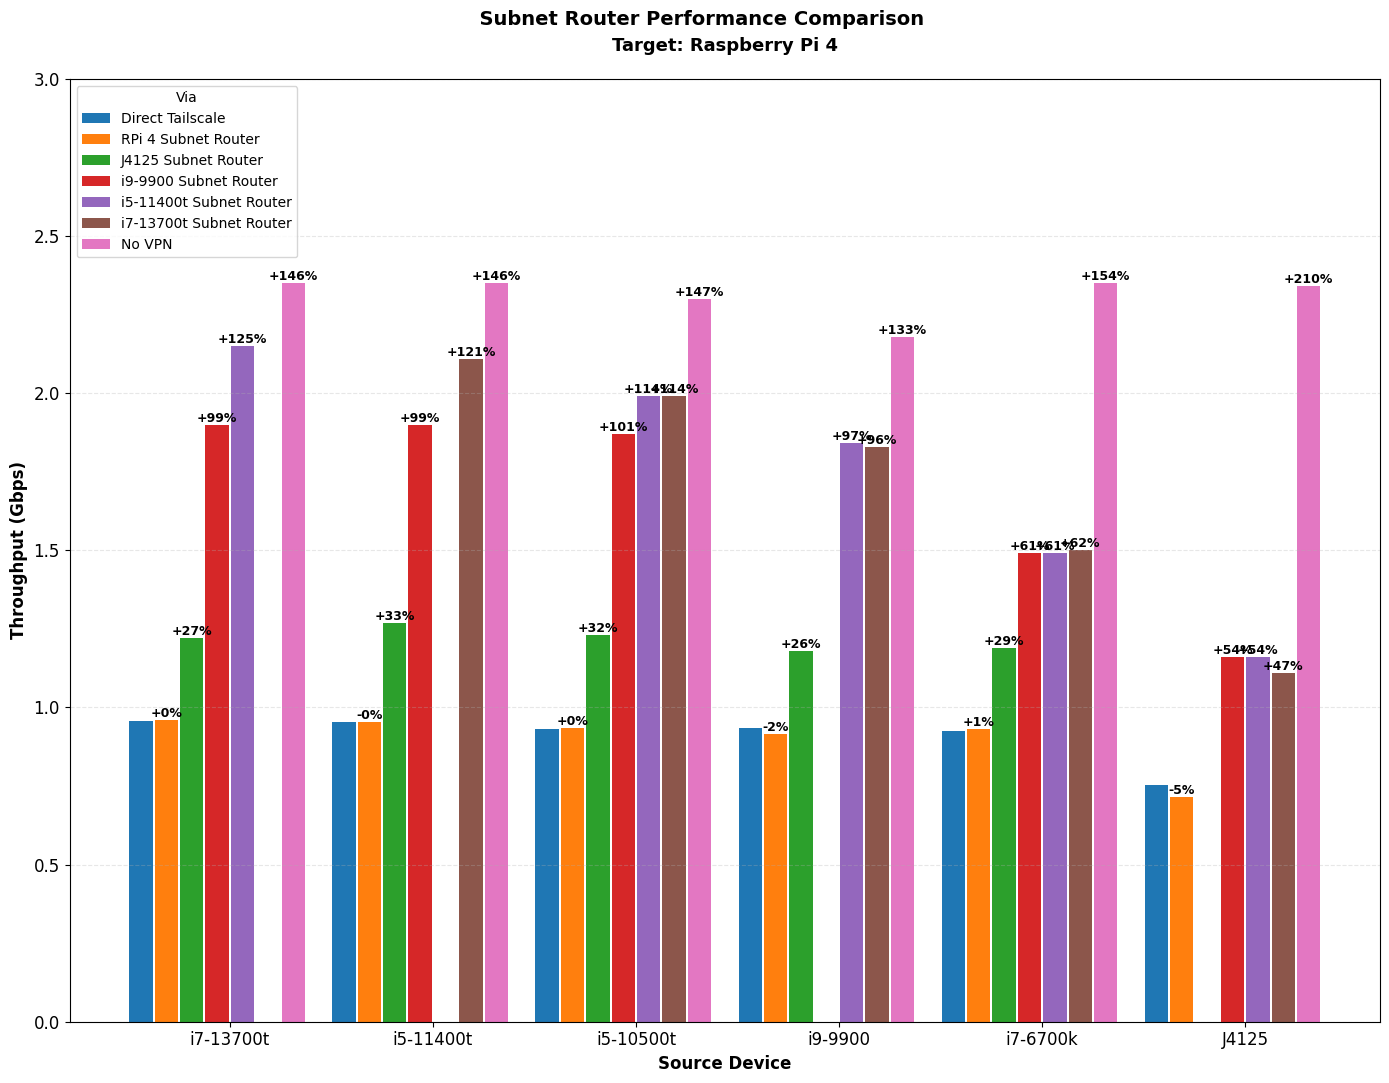

In [20]:
compare_subnet_routers(
    df_sr=df_sr_pi_forward,
    target_cpu="RPi 4",
    target_name="Raspberry Pi 4",
)

Saved to output/sr-target-j4125.png


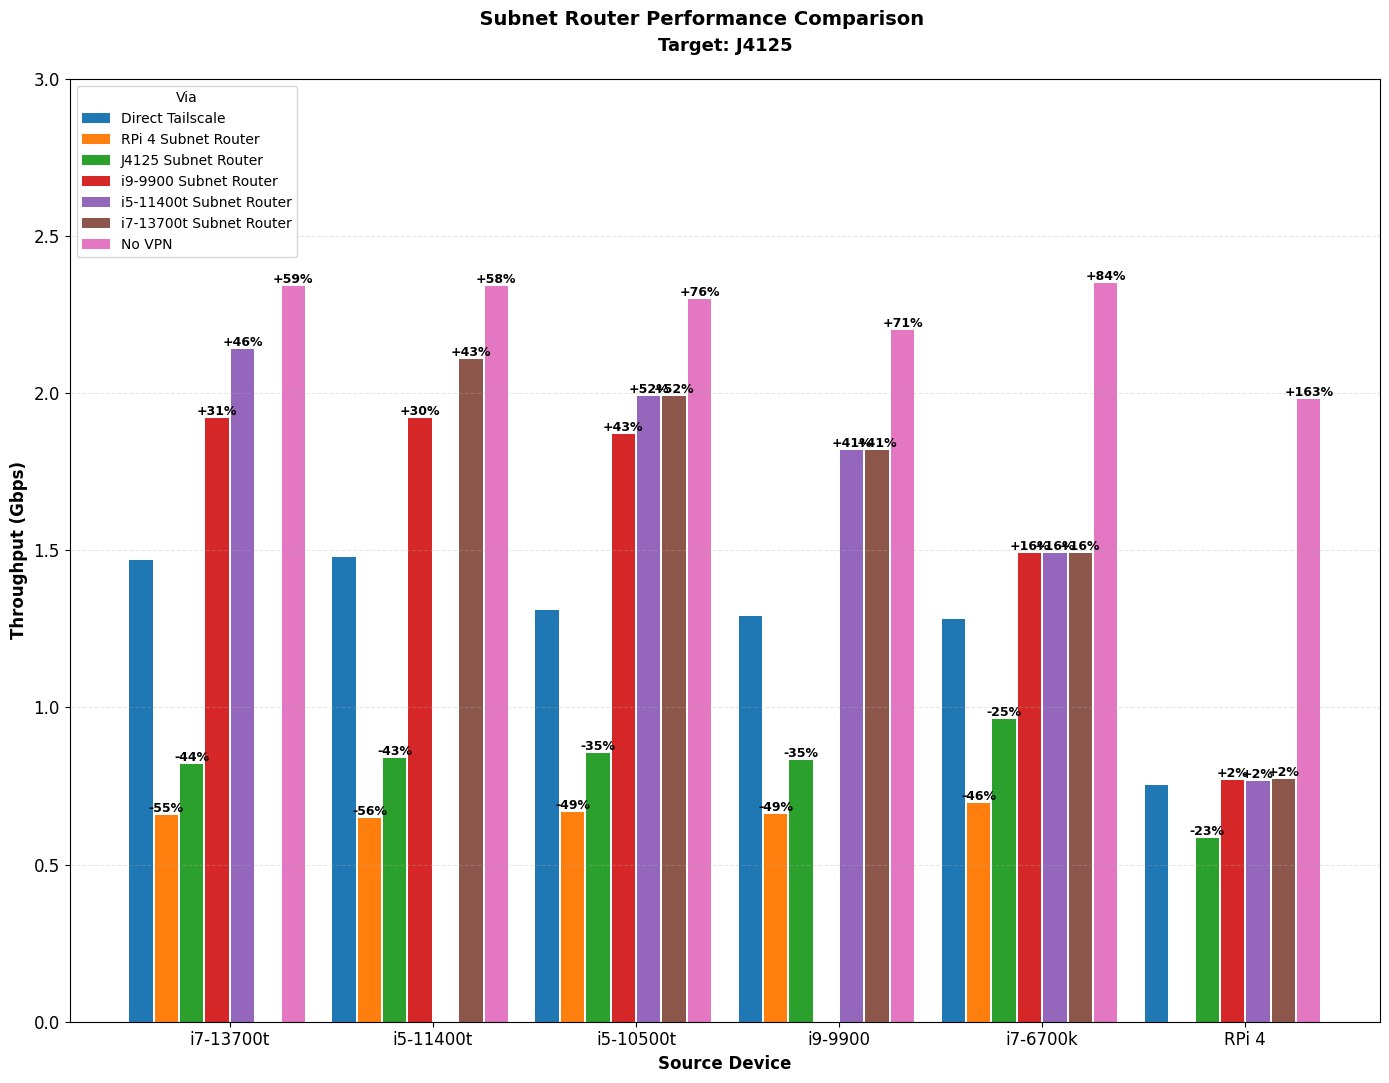

In [21]:
compare_subnet_routers(
    df_sr=df_sr_ds920_forward,
    target_cpu="J4125",
)

# Add a footnote to this one about Synology behaviour routing to self

Saved to output/sr-target-i5-10500t.png


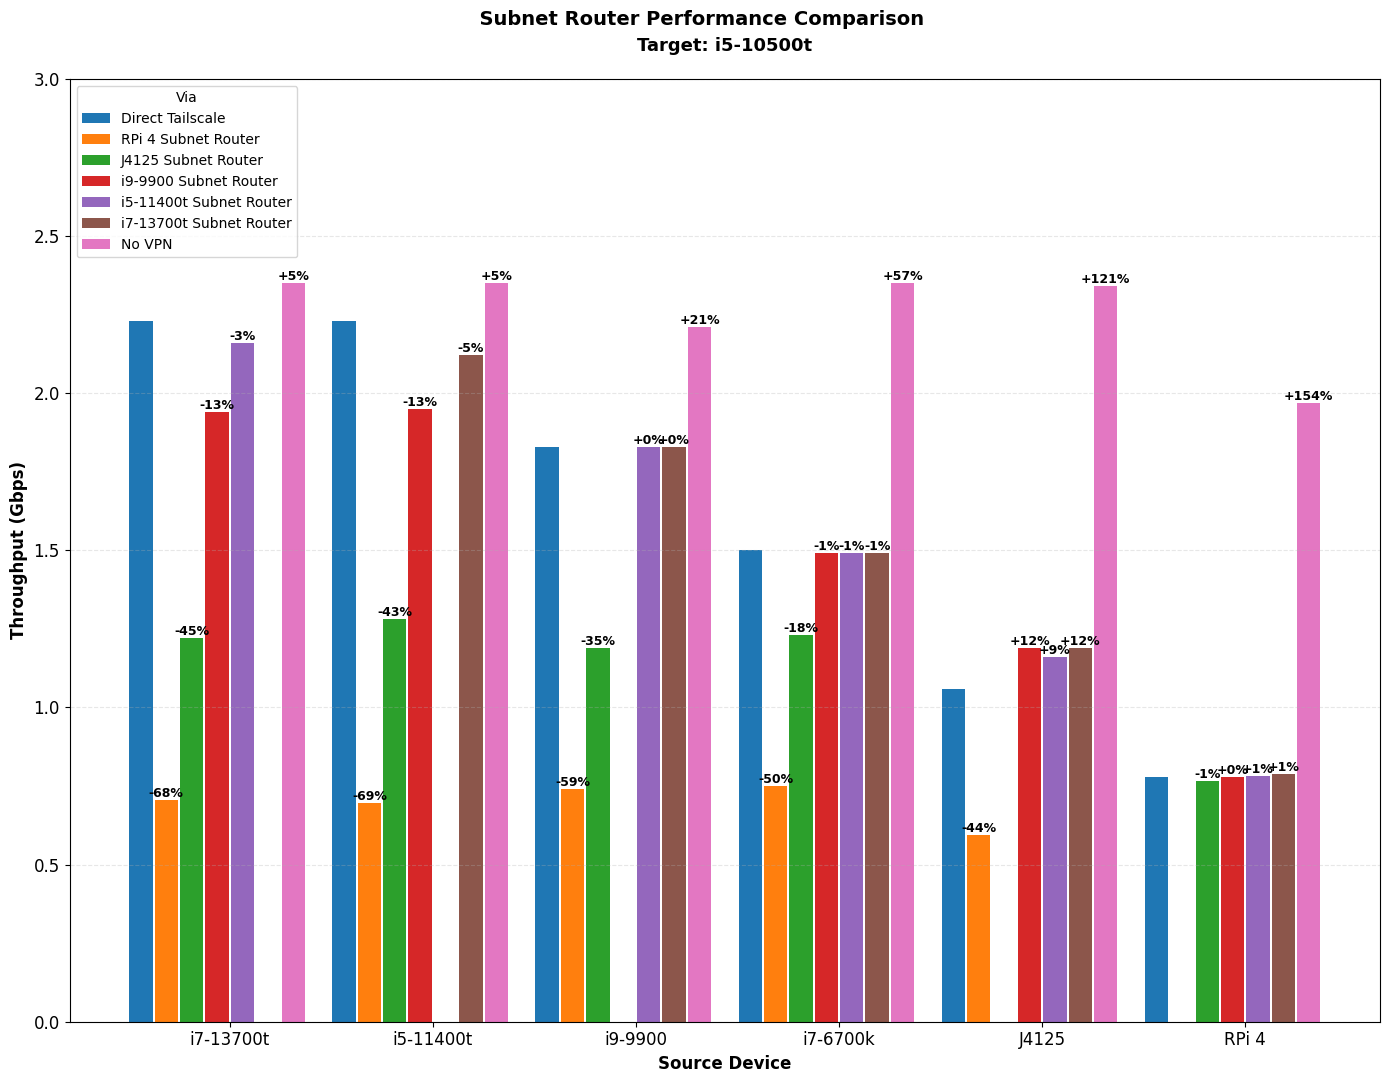

In [22]:
compare_subnet_routers(
    df_sr=df_sr_pve2_forward,
    target_cpu="i5-10500t"
)